#Importation of libraries

In [8]:
import pandas as pd
import csv
from transformers import RobertaModel, RobertaTokenizer
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim

#Data preprocessing

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_df = pd.read_csv('/content/drive/MyDrive/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/test.csv')

In [4]:
train_df.head(5)

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [5]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [6]:
# Check for non-numeric entries
train_df[['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']] = train_df[['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']].apply(pd.to_numeric, errors='coerce')
# Check for NaNs
print(train_df[['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']].isna().sum())


cohesion       0
syntax         0
vocabulary     0
phraseology    0
grammar        0
conventions    0
dtype: int64


#LSTM

##Tokenizing

In [9]:
class TextDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.tokenizer = tokenizer
        self.texts = dataframe['full_text'].tolist()
        self.labels = dataframe[['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']].values
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Tokenize and prepare for the model
        encoding = self.tokenizer(
            self.texts[idx],
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].squeeze(0)  # Remove batch dimension
        attention_mask = encoding['attention_mask'].squeeze(0)
        return input_ids, torch.tensor(self.labels[idx], dtype=torch.float)

train_dataset = TextDataset(train_df, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

##LSTM Set Up

In [10]:
class EssayLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(EssayLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, input_ids, attention_mask=None):
        embedded = self.embedding(input_ids)
        # Apply LSTM
        lstm_output, (hidden, cell) = self.lstm(embedded)
        # Process output
        output = self.fc(hidden[-1])
        return output

# Set vocab_size to the tokenizer's vocabulary size
vocab_size = tokenizer.vocab_size
model = EssayLSTM(vocab_size, 100, 128, 6)

##Training and results

Epoch 1, Loss: 9.743959039207397
Epoch 2, Loss: 8.544883181409139
Epoch 3, Loss: 7.04199545557906
Epoch 4, Loss: 5.221093361939841
Epoch 5, Loss: 1.858283344323073
Epoch 6, Loss: 0.5576043550561114
Epoch 7, Loss: 0.44068820495915606
Epoch 8, Loss: 0.42705357365491914
Epoch 9, Loss: 0.429060939487403
Epoch 10, Loss: 0.4256151018103933


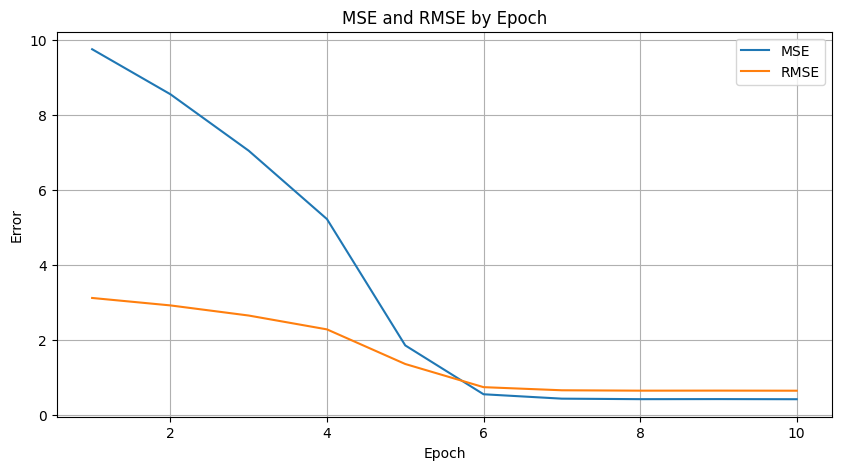

Metrics saved to /content/drive/MyDrive/LSTM_model_metrics.npy


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)
criterion = nn.MSELoss()

# Prepare lists to store the metrics
mse = []
rmse = []

# Training loop
model.train()
for epoch in range(10):
    total_loss = 0
    for input_ids, labels in train_loader:
        input_ids, labels = input_ids.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Calculate average loss for the current epoch
    average_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1}, Loss: {average_loss}')

    # Store the MSE and calculate/store the RMSE
    mse.append(average_loss)
    rmse.append(np.sqrt(average_loss))

# Plotting MSE and RMSE
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), mse, label='MSE')
plt.plot(range(1, 11), rmse, label='RMSE')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('MSE and RMSE by Epoch')
plt.legend()
plt.grid(True)
plt.savefig('/content/drive/MyDrive/LSTM_model_performance_metrics.png')
plt.show()

# Saving the metrics to a file
metrics_path = '/content/drive/MyDrive/LSTM_model_metrics.npy'
np.save(metrics_path, np.array([mse, rmse]))
print(f"Metrics saved to {metrics_path}")

In [12]:
#Save the model weights to a file
torch.save(model.state_dict(), '/content/drive/MyDrive/EssayLSTM_model_weights.pt')